In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
import xgboost as xgb
import cvxpy as cp

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

In [5]:
X, Y = data.load_unbalanced_german()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
subgroup_train = X_train.Sex.values
subgroup_test = X_test.Sex.values

## Model without fairness

In [6]:
parameters = {
    "n_estimators" : [5, 10, 20, 50, 100, 250],
    "colsample_bytree" : [0.1, 0.25, 0.5, 0.75],
    "max_depth" : [3, 4, 5, 8, 10],
    "l2_weight" : [0.01, 0.1, 1, 10, 100,],
    "eta" : [0.1, 0.2, 0.3],
}
cv = GridSearchCV(models.XGBoostWrapper(), parameters,  scoring = "roc_auc")
cv.fit(X_train, Y_train)
idx = np.argmax(cv.cv_results_["mean_test_score"])
best_score = cv.cv_results_["mean_test_score"][idx]
best_score_std = cv.cv_results_["mean_test_score"][idx]
cv.best_params_, f"{best_score:.3f} +/- {best_score_std:.3f}"

({'colsample_bytree': 0.75,
  'eta': 0.1,
  'l2_weight': 0.1,
  'max_depth': 3,
  'n_estimators': 20},
 '0.770 +/- 0.770')

In [7]:
utils.eval_model_train_test(
    cv,
    X_train, Y_train, subgroup_train,
    X_test, Y_test, subgroup_test,
)

,roc,tpr,fnr,threshold,accuracy,precision,name
0,0.857800,0.700957,0.299043,0.719626,0.746141,0.927215,train_g0
1,0.887755,0.761905,0.238095,0.719626,0.777778,0.888889,train_g1
2,0.732194,0.703704,0.296296,0.719626,0.710280,0.890625,test_g0
3,1.000000,0.800000,0.200000,0.719626,0.857143,1.000000,test_g1


## Model with reinforcement for woman

In [8]:
parameters = {
  'colsample_bytree': [0.75],
  'eta': [0.1],
  'l2_weight': [0.1],
  'max_depth': [3],
  'n_estimators': [20]
}

In [9]:
def logloss_grad(predt, dtrain):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    return grad

def logloss_hessian(predt, dtrain):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    return hess

In [10]:
def logloss_grad_unpr(predt, dtrain, subgroup):
    '''Compute the gradient for log loss.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)
    grad[subgroup == 0] = 0
    return grad

def logloss_hessian_unpr(predt, dtrain, subgroup):
    '''Compute the hessian for log loss.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))
    hess[subgroup == 0] = 0
    return hess

In [11]:
def obj_penalize_group_1(subgroup_idx, fair_weight):
    def custom_obj(predt, dtrain):
        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        weight_1 = 1 / len(subgroup)
        weight_2 = fair_weight / subgroup.sum()
        sum_weights = (weight_1 + weight_2)
        weight_1 /= sum_weights
        weight_2 /= sum_weights
        grad = weight_1 * logloss_grad(predt, dtrain) + weight_2 * logloss_grad_unpr(predt, dtrain, subgroup)
        hess = weight_1 * logloss_hessian(predt, dtrain) + weight_2 * logloss_hessian_unpr(predt, dtrain, subgroup)
        return grad, hess
    return custom_obj

In [12]:
lambda_values = np.append([0],np.logspace(-3, 3, num=20))
results = []
for lambda_value in tqdm(lambda_values):
    cv = GridSearchCV(models.XGBoostWrapper(objective = obj_penalize_group_1(0, lambda_value)), parameters, scoring = "roc_auc")
    cv.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        cv,
        X_train, Y_train, subgroup_train,
        X_test, Y_test, subgroup_test,
    )
    results_df["lambda"] = lambda_value
    results_df["best_params"] = str(cv.best_params_)
    results.append(results_df)
results = pd.concat(results)

100%|██████████| 21/21 [00:05<00:00,  3.59it/s]


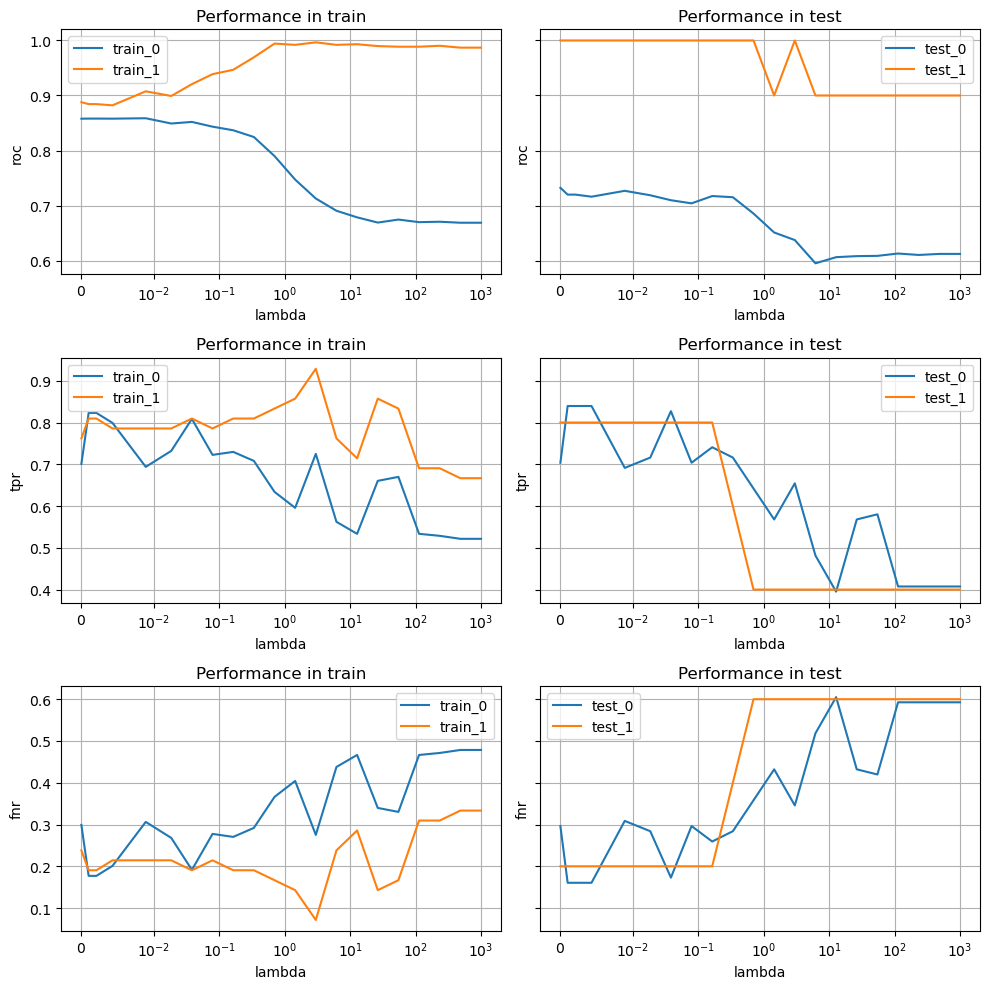

In [13]:
utils.comparison_subgrous_metrics_lambda(results)

## Model with dual step

In [14]:
def logloss_group(predt, dtrain, subgroup):
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    loss = - (y * np.log(predt) + (1 - y) * np.log(1 - predt))
    groups = np.unique(subgroup)
    loss_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        loss_matrix[:, i] = loss # copy the column
        loss_matrix[subgroup!= group, i] = 0 # and set 0 for other groups

    loss_matrix = np.sum(loss_matrix, axis = 0)  / np.sum(loss_matrix != 0, axis = 0)
    return loss_matrix


def logloss_grad_group(predt, dtrain, subgroup):
    '''Compute the gradient for log loss for each group.'''
    y = dtrain.get_label()
    predt = 1 / (1 + np.exp(-predt))
    grad = -(y - predt)

    groups = np.unique(subgroup)
    grad_matrix = np.zeros((len(y), len(groups)))

    for i, group in enumerate(groups):
        grad_matrix[:, i] = grad # copy the column
        grad_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return grad_matrix


def logloss_hessian_group(predt, dtrain, subgroup):
    '''Compute the hessian for log loss for each group.'''
    predt = 1 / (1 + np.exp(-predt))
    hess = (predt * (1 - predt))

    groups = np.unique(subgroup)
    hess_matrix = np.zeros((len(hess), len(groups)))

    for i, group in enumerate(groups):
        hess_matrix[:, i] = hess # copy the column
        hess_matrix[subgroup!= group, i] = 0 # and set 0 for other groups
    return hess_matrix

In [15]:
def penalize_max_loss_subgroups(subgroup_idx, fair_weight):
    weight_1 = 1 / (1 + fair_weight)
    weight_2 = fair_weight / (1 + fair_weight)
    
    def custom_obj(predt, dtrain):

        subgroup = (dtrain.get_data()[:, subgroup_idx]).toarray().reshape(-1)
        
        if weight_2 > 0:
            # dual problem
            loss_group = logloss_group(predt, dtrain, subgroup)
            mu = cp.Variable(loss_group.shape[0]) # number of groups
            z = cp.Variable(1) # z is the min of mu * loss
            constraints = [cp.sum(mu) == weight_2, mu >= 0] + [z <= mu[i] * loss_group[i] for i in range(loss_group.shape[0])]
            objective = cp.Maximize(z)
            problem = cp.Problem(objective, constraints)
            problem.solve()

            # primal problem
            mu_opt = mu.value
        else:
            mu_opt = np.zeros(len(np.unique(subgroup)))
            
        grad_group = logloss_grad_group(predt, dtrain, subgroup)
        hess_group = logloss_hessian_group(predt, dtrain, subgroup)
        grad = logloss_grad(predt, dtrain) * weight_1 + np.sum(mu_opt * grad_group, axis=1) 
        hess = logloss_hessian(predt, dtrain) * weight_1 + np.sum(mu_opt * hess_group, axis=1)

        return grad, hess
    return custom_obj

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


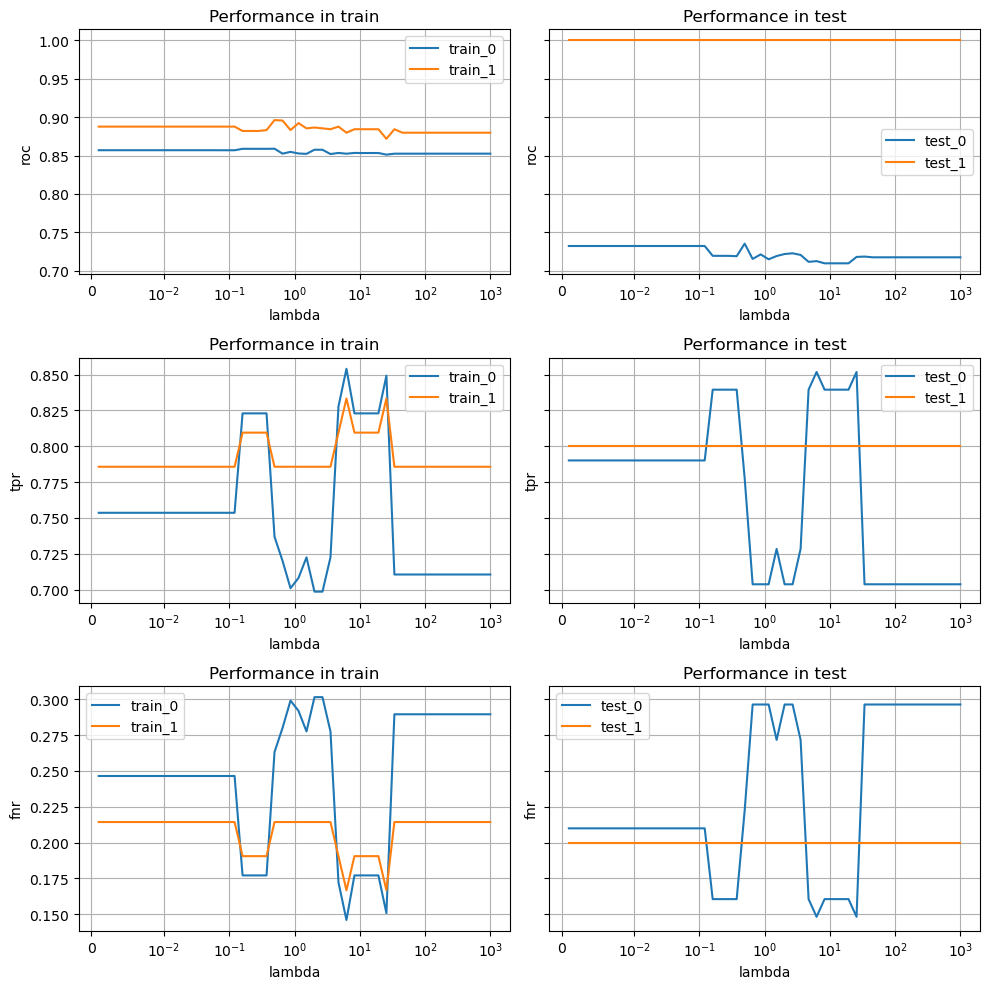

In [16]:
lambda_values = np.append([0],np.logspace(-3, 3, num=50))
results = []
for lambda_value in tqdm(lambda_values[1:]):
    cv = GridSearchCV(models.XGBoostWrapper(objective = penalize_max_loss_subgroups(0, lambda_value)), parameters, scoring = "roc_auc")
    cv.fit(X_train, Y_train)
    results_df = utils.eval_model_train_test(
        cv,
        X_train, Y_train, subgroup_train,
        X_test, Y_test, subgroup_test,
    )
    results_df["lambda"] = lambda_value
    results_df["best_params"] = str(cv.best_params_)
    results.append(results_df)
results = pd.concat(results)
utils.comparison_subgrous_metrics_lambda(results)

In [17]:
utils.eval_model_train_test(
    cv,
    X_train, Y_train, subgroup_train,
    X_test, Y_test, subgroup_test,
)

,roc,tpr,fnr,threshold,accuracy,precision,name
0,0.852530,0.710526,0.289474,0.710341,0.746141,0.916667,train_g0
1,0.879819,0.785714,0.214286,0.710341,0.793651,0.891892,train_g1
2,0.717474,0.703704,0.296296,0.710341,0.710280,0.890625,test_g0
3,1.000000,0.800000,0.200000,0.710341,0.857143,1.000000,test_g1
